# Algoritmo de Audio Fingerprinting - Shazam

<div style = "font-size:12px">

Programación 1ºGIA


- Verónica Ramírez Alejandro

- Helena Ramos Muradás

- Ginés Reinoso Blanco

- Oriol Rodríguez Hernández


## Introducción

El reto consiste en implementar los algoritmos elementales que utilizan aplicaciones de reconocimiento de audio, como Shazam, haciendo uso de Python.

El reconocimiento automático de audio es una tecnología ampliamente utilizada en aplicaciones modernas como Shazam, así como en diversas herramientas de Inteligencia Artificial que procesan sonido. Este mecanismo permite identificar canciones a partir de fragmentos muy breves de audio, incluso en ambientes ruidosos. Su funcionamiento se basa en el concepto de _audio fingerprinting_ (huella digital de audio), que consiste en extraer una firma única a partir de las características espectrales del sonido.
El objetivo de este proyecto es implementar una versión simplificada de este algoritmo utilizando Python.

El código presentado aborda las nociones fundamentales del mecanismo original de Shazam. El programa permite cargar y visualizar audio, generar su espectrograma, detectar picos relevantes en el dominio tiempo-frecuencia y construir hashes que puedan utilizarse para comparar distintas grabaciones. Sin embargo, no incluye funcionalidades como la captura de audio mediante micrófono ni el manejo de una base de datos completa con huellas digitales de canciones.


## 1. Cargar audio y forma de onda



En esta sección se presentan las herramientas principales y el mecanismo más básico de manipulación de audio de este programa.

Primero importamos las siguientes librerías:

- _Essentia_: Para manipular archivos de audio.

- _Matplotlib_: Para pintar gráficas.

- _NumPy_: Para tratamiento de vectores, matrices y cálculo numérico en general.


In [65]:
import essentia.standard as es
import matplotlib.pyplot as plt
import numpy as np

Asignamos a la variable "audio_path" la ruta del archivo de audio que queremos cargar.

In [66]:
audio_path = "/mnt/c/Users/Oriol/Music/4K YouTube to MP3/Je te veux (I want you).mp3"


Le aplicamos la función [_MonoLoader_](https://essentia.upf.edu/reference/std_MonoLoader.html) de Essentia, que transforma el audio en mono y devuelve un array inmenso de NumPy. Cada elemento de ese array corresponde al valor de amplitud de la señal en un instante del tiempo, lo que nos permite trabajar directamente con la forma de onda.

In [67]:
loader = es.MonoLoader(filename=audio_path)
audio = loader()

In [68]:
print(audio)

[-6.93984548e-05 -1.15973424e-04 -1.32002242e-04 ...  8.24066403e-04
  7.44077202e-04  9.37503122e-04]


Finalmente, con matplotlib, graficamos la señal de onda del audio.

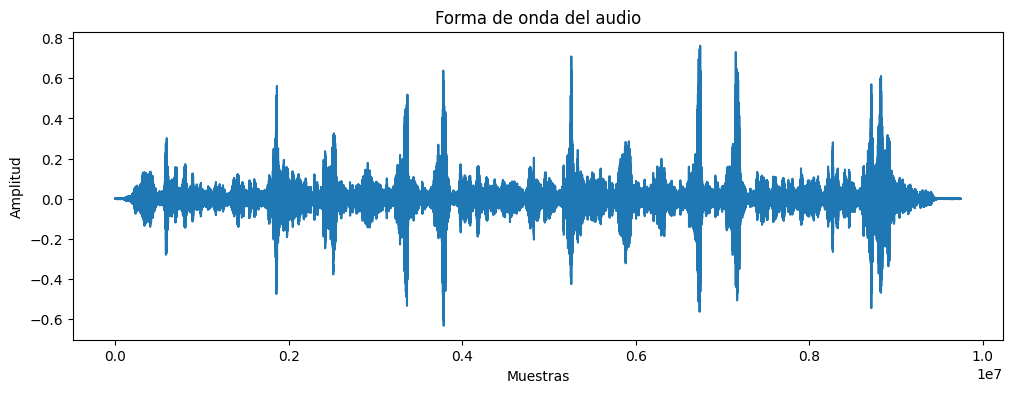

In [69]:
plt.figure(figsize=(12, 4))
plt.plot(audio)
plt.title("Forma de onda del audio")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.show()

## 2.  Espectrograma

La forma de onda que acabamos de obtener contiene información sobre la amplitud de la onda, la cual está relacionada con la percepción de volumen del sonido. Sin embargo, esta cualidad por sí sola describe muy poco de lo que hace interesante a la música.

Una cualidad fundamental del sonido es la frecuencia, que determina principalmente la altura o afinación de un sonido: a frecuencias más altas, el sonido se percibe más agudo; a frecuencias más bajas, más grave. Además, la frecuencia y la estructura armónica del sonido también son responsables del timbre. Cada instrumento, al tocar una nota, produce no solo la frecuencia fundamental sino también una _serie de armónicos_, que son tonos elementales que se combinan. Esta combinación le da a la nota una afinación común con otros instrumentos, pero un timbre único que permite distinguir, por ejemplo, un piano de una flauta aunque toquen la misma nota.

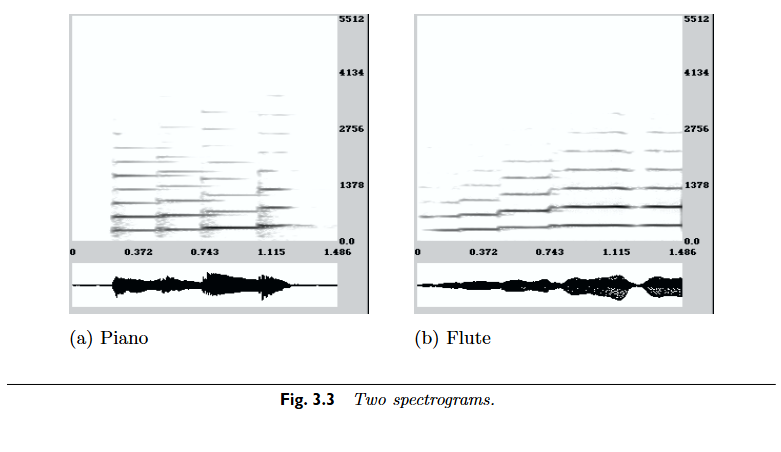

Por suerte, obtener estos diagramas frecuencia-tiempo se convierte en una tarea bastante trivial gracias a las herramientas de _Essentia._

Estas herramientas utilizan técnicas matemáticas basadas en las Transformadas de Fourier:
- FFT (Fast Fourier Transform): es un algoritmo eficiente para calcular la transformada de Fourier de una señal, que nos muestra todas las frecuencias presentes en un instante dado, pero sin información de cómo cambian a lo largo del tiempo.

- STFT (Short-Time Fourier Transform): divide la señal en pequeñas ventanas de tiempo y aplica la FFT en cada ventana. Esto genera un mapa tiempo-frecuencia, donde podemos ver cómo evolucionan las frecuencias y armónicos con el tiempo, lo que es crucial para identificar características únicas en una huella de audio.

En esencia, las Transformadas de Fourier nos indican cuánta energía tiene cada frecuencia: qué frecuencias hay y con qué intensidad.

La idea es programar un algoritmo sencillo de STFT que se aplique al audio que carguemos. Para ello usaremos la función [_FrameGenerator_](https://essentia.upf.edu/reference/std_FrameGenerator.html) para crear las ventanas, y la función [_Spectrum_](https://essentia.upf.edu/reference/std_Spectrum.html) para aplicar la FFT a cada ventana. Para usar la primera, necesitamos definir un tamaño para las ventanas y un salto entre las ventanas generadas.

In [70]:
frame_size = 2048  # Tamaño de las ventanas
hop_size = 512     # Salto entre las ventanas generadas
window = es.Windowing(type='hann')
spectrum = es.Spectrum()

Cada _frame_ del audio tiene 2048 muestras y cada _frame_ nuevo empieza 512 muestras después del anterior. Esto causa un soplamiento bastante grande (75%) que es necesario para que el espectograma tenga buena resolución y haya suavidad entre las ventanas. Además, la librería también cuenta con una serie de funciones de suavizamiento (_windowing_ en inglés), que conviene aplicar también a cada ventana para mejorar aún más la resolución y corregir los saltos bruscos. Al aplicar la FFT en una ventana, el algoritmo asume que esa muestra es periódica, sin embargo, las muestras se toman de formar arbitraria y no tienen por qué serlo, por lo que surgen estos "saltos bruscos". El nombre técnico es "artefactos de borde" (_spectral leakage_).

Estas funciones están aglutinadas dentro de la función [_Windowing_](https://essentia.upf.edu/reference/std_Windowing.html) y se selecciona la deseada indicanto el tipo (_type=_). Para nuestro caso, conviene la curva de "Hann", que ofrece un buen equilibrio entre resolución de los picos principales y supresión de los secundarios, y corrige bastante bien los artefactos de borde.

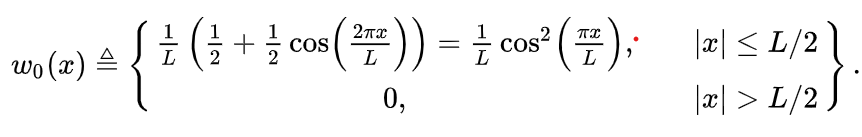 
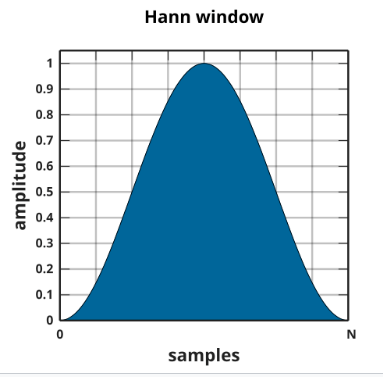

<div style = "font-size: 1 px">

La expresión analítica de la función Hann y su representación. [Consulte aquí](https://en.wikipedia.org/wiki/Hann_function)

<div>

Antes de iniciar la STFT, asignamos una lista vacía a la variable _spectrogram_, en la que almacenaremos las distintas magnitudes de frecuencia que devuelve la FFT.

In [71]:
spectrogram = []

El siguiente bucle aplica la STFT al audio cargado.

In [72]:
for frame in es.FrameGenerator(audio, frameSize=frame_size, hopSize=hop_size, startFromZero=True):
    mag = spectrum(window(frame))
    spectrogram.append(mag)


Antes de graficar el espectrograma, hay que transformar la lista en array de NumPy y hacer la traspuesta, porque la función FFT de Essentia devuelve vectores tiempo-frecuencia, y nosotros queremos manejar vectores frecuencia-tiempo. También conviene comentar que generalmente los espectrogramas se grafican con los decibelios, ya que nuestro oído percibe la intensidad de las frecuencias de forma logarítmica, no lineal, y también porque la función FFT devuelve números en un rango muy grande, por que lo que podrían no ser perciptibles los distintos niveles energía.

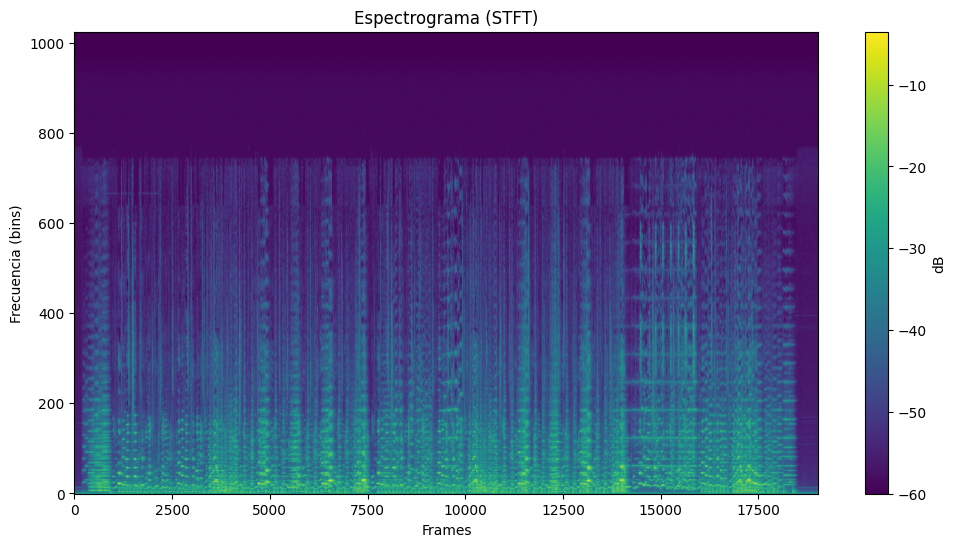

In [73]:
spectrogram = np.array(spectrogram).T
plt.figure(figsize=(12, 6))
plt.imshow(10 * np.log10(spectrogram + 1e-6), aspect='auto', origin='lower') 
plt.title("Espectrograma (STFT)") 
plt.xlabel("Frames") 
plt.ylabel("Frecuencia (bins)") 
plt.colorbar(label="dB") 
plt.show()

## 3.  Detección de picos  

Este es uno de los puntos más importantes de todo el algoritmo de generación de huellas digitales de audio. Shazam, y aplicaciones similares, toman sólo los puntos más significativos del espectrograma porque en su gran mayoría sobreviven al ruido, por lo que la funcionalidad de detección de audio vía micrófono apenas se ve perturbada en condiciones de grabación no óptimas. A estos puntos se le llaman "picos" o "peaks". 

Para detectar estos picos, primero importamos la función [*maximum_filter*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html#scipy.ndimage.maximum_filter) del subpaquete _scipy.ndimage_.
Esta función aplica un filtro que reemplaza cada elemento por el máximo dentro de una vecindad (ventana) alrededor de ese elemento. Se usa para detectar máximos locales (nuestro picos).

In [74]:
from scipy.ndimage import maximum_filter

A continuación, se indican los siguientes parámetros para la detección de picos:

In [75]:
neighborhood = 20          # Tamaño del entorno para buscar máximos locales
threshold_ratio = 0.5      # Relación respecto al máximo global

La función *maximun_filter* toma como entrada un array de NumPy y el tamaño del entorno o la vecindad de en el que se buscan los máximos.

In [76]:
local_max = maximum_filter(spectrogram, size=neighborhood) == spectrogram

amplitude_threshold = threshold_ratio * spectrogram.max()

peak_coords = np.where(local_max & (spectrogram > amplitude_threshold))

El objeto *local_max* es una matriz booleana obtenida de hacer una máscara booleana al resultado de aplicar *maximum_filter* sobre el espectrograma. Básicamente, es un array que contiene los máximos locales del espectrograma. Después, se define un umbral para reducir bastante el ruido *(amplitude_threshold)*. Finalmente, con la función [_where_](https://numpy.org/doc/stable/reference/generated/numpy.where.html) de NumPy, obtenemos las coordenadas de los picos significativos (*peak_coords*), despreciando todos los picos no significativos (50% de la intensidad máxima).

Estas coordenadas son de la forma:
- peak_coords[0] : Índices de frecuencia (filas del espectrograma)
- peak_coords[1] : Índices de tiempo (columnas del espectrograma)

In [77]:
peaks = list(zip(peak_coords[0], peak_coords[1]))

Usando herramientas básicas de Python, creamos la lista con todos los picos, en la que cada elemento tiene una tupla del tipo frecuencia-tiempo, es decir, las coordenadas de cada pico.

In [78]:
print(f"Total de picos detectados: {len(peaks)}")

Total de picos detectados: 26


Ya con los picos almacenados, podemos proceder a visualizarlos.

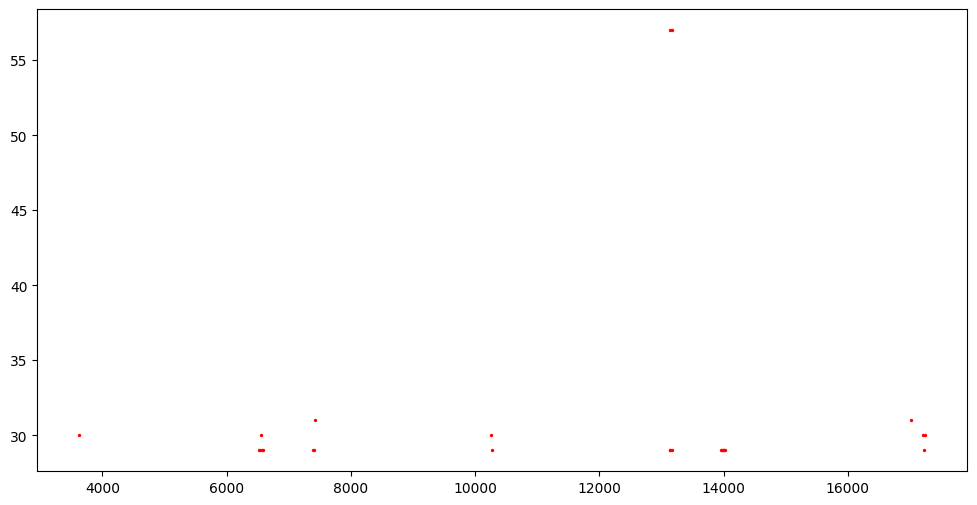

In [79]:
plt.figure(figsize=(12, 6))
plt.scatter(peak_coords[1], peak_coords[0], s=2, c='red')

Text(0, 0.5, 'Frecuencia (bins)')

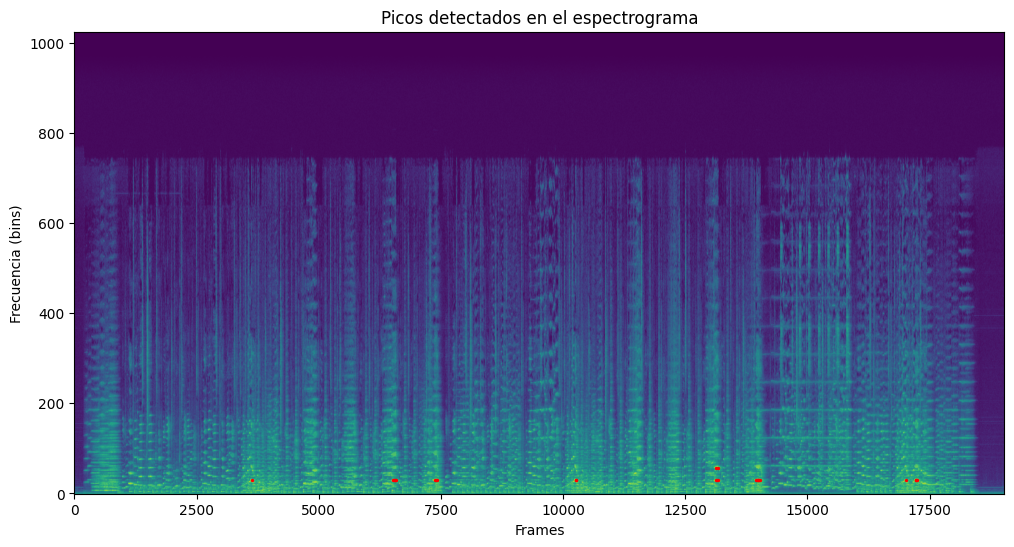

In [80]:
plt.figure(figsize=(12, 6))
plt.imshow(10 * np.log10(spectrogram + 1e-6), aspect='auto', origin='lower')
plt.scatter(peak_coords[1], peak_coords[0], s=2, c='red')
plt.title("Picos detectados en el espectrograma")
plt.xlabel("Frames")
plt.ylabel("Frecuencia (bins)")

## 4. Generar hashes a partir de los picos

Una función resumen, o más comunmente conocida como función hash (_hash function_, en inglés), convierte uno o varios elementos de entrada a otro elemento de longitud fija y finita mediante un complejo algoritmo.

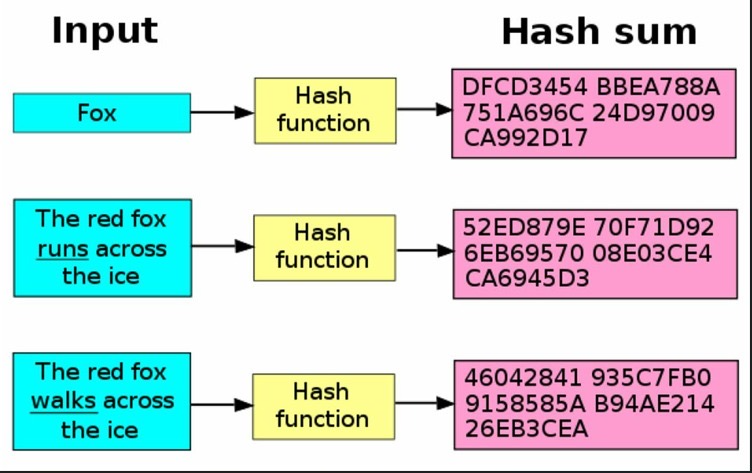

A la salida generalmente se le conoce simplemente como hash, y es una serie de carácteres única para cada valor de entrada. Esta característica es la que motiva el uso de este tipo de funciones en, por ejemplo, cuestiones de criptografía, o, especialmente para este proyecto, para crear la huella digital de las canciones.

Shazam crea los hashes de la siguiente manera:

1. Toma un pico de intensidad y almacena su frecuencia e instante de tiempo
    - (f1, t1)

2. Hace lo mismo con el siguiente pico
    - (f2, t2)

3. Agrupa ambas frecuencias con el incremento de tiempo entre los picos
    - (f1, f2, delta_t)

4. Esto se hace para un número arbitrario de picos posteriores al tomado inicialmente
    - (supongamos que para 5)

5. Repite el proceso para todos los picos

6. Aplica una función hash a estas ternas de números y almacena su salida junto con su instante de tiempo inicial
    - (h, t1)


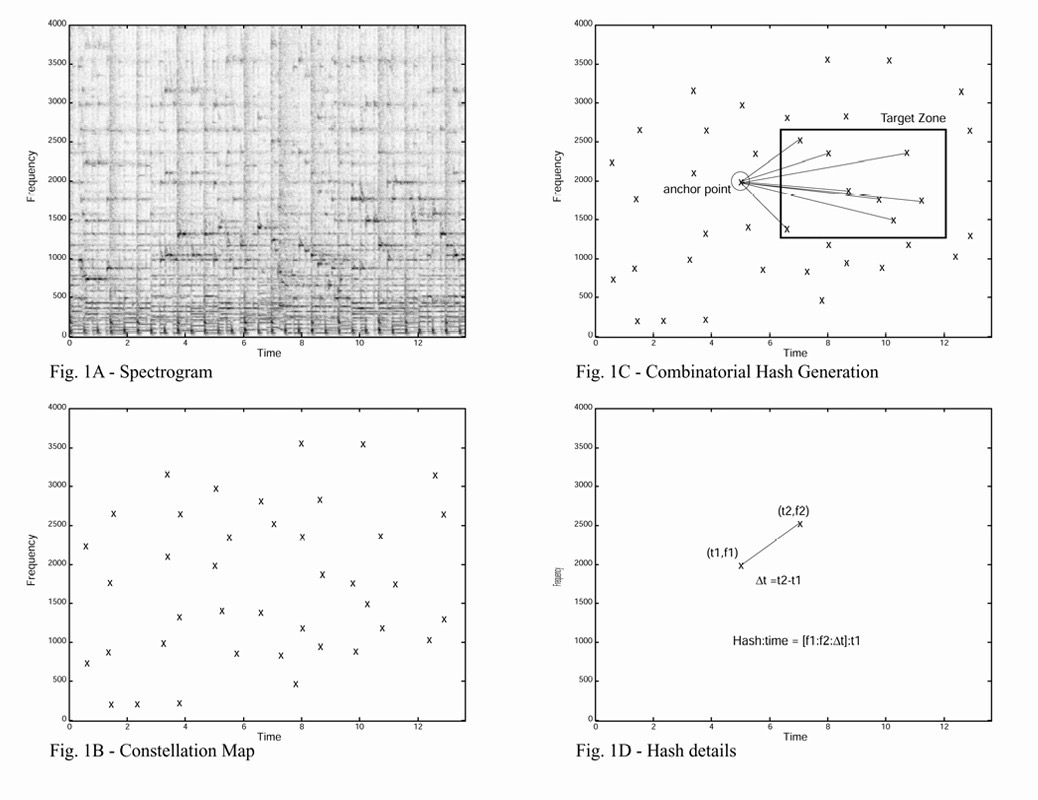

<div style = "font-size: 7 px">

[Consulte aquí.](https://ursinus-cs174-s2022.github.io/CoursePage/Assignments/FinalProject_Shazam/Wang03-shazam.pdf)

Una vez entendido esto, solo hay que volcarlo al código. Para ello definimos la función *generate_hashes*, que tomará como entrada los picos detectados, el número de picos con los que haremos las combinaciones _(fanout)_, y un criterio de parada *max_time_delta* para que solo considere los picos suficientemente cercanos a la hora de hacer las combinaciones. Esto último agiliza el cálculo de hashes para archivos de audio muy largos.

In [81]:
def generate_hashes(peaks, fanout=5, max_time_delta=50):
    """
    Genera hashes de audio a partir de picos espectrales.

    Parámetros
    ----------
    peaks : list of tuple (int, int)
        Lista de picos (frecuencia, tiempo).
    fanout : int
        Número de picos posteriores a combinar.
    max_time_delta : int
        Máxima separación temporal permitida entre picos.

    Salida
    -------
    list of tuple (int, int)
        Lista de hashes y su tiempo de referencia.
    """
    hashes = []

    # Ordenar picos por tiempo (2º elemento de la tupla)
    peaks_sorted = sorted(peaks, key=lambda x: x[1]) 

    for i in range(len(peaks_sorted)):
        f1, t1 = peaks_sorted[i]

        # Emparejar con los siguientes picos cercanos
        for j in range(1, fanout):
            if i + j < len(peaks_sorted):
                f2, t2 = peaks_sorted[i + j]
                delta_t = t2 - t1

                # Ignorar si están muy lejos en el tiempo
                if 0 < delta_t <= max_time_delta:
                    h = hash((f1, f2, delta_t))
                    hashes.append((h, t1))

    return hashes


Primero, la función crea una lista vacía _(hashes)_ en la que almacenará los hashes más adelante. Después, haciendo acopio de la función  [_sorted_](https://docs.python.org/3/library/functions.html#sorted) de Python, ordena los picos en orden cronológico. El primer bucle, que itera sobre i, le asigna a las variables f1 y t1 las frecuencias y tiempos de los picos ya ordenados. El siguiente bucle, que itera sobre j, combina los siguientes picos con el pico i y calcula *delta_t*. Finalmente, si esta diferencia de tiempo es lo suficientemente grande (cercana a *max_time_delta*), entonces concluye calculando los hashes, para lo que aplica la función [_hash_](https://docs.python.org/3/library/functions.html#hash) de Python a la terna (f1, f2, delta_t) y guarda su salida en la variable *h*. En la lista *hashes* se guardan tuplas con cada *h* y su *t1*.

La huella digital de la canción, llamémosla con la variable *fingerprints*, será la función *generate_hashes* aplicada a *peaks*:

In [82]:
fingerprints = generate_hashes(peaks)

print(fingerprints)

[(-1218012422271888933, np.int64(6517)), (-4705355500974715805, np.int64(6517)), (-8771744527159331393, np.int64(6517)), (-8552338181161968136, np.int64(6542)), (-1218012422271888933, np.int64(6542)), (167389820523515403, np.int64(6542)), (8199967626395273450, np.int64(6556)), (-8861374204518873830, np.int64(6556)), (-3679592859663736928, np.int64(6567)), (4213450139233665833, np.int64(7385)), (6411256697021893752, np.int64(7385)), (-2867188544670913345, np.int64(7408)), (1692326870293275025, np.int64(10258)), (4022767914070571539, np.int64(13130)), (4937331269555891794, np.int64(13130)), (1336613749249279413, np.int64(13130)), (-7577024509527021351, np.int64(13130)), (-4997627221630824639, np.int64(13136)), (5450041948787746468, np.int64(13136)), (7937118475086140495, np.int64(13136)), (5382674067959429843, np.int64(13143)), (7869750594257823870, np.int64(13143)), (-2577918576160747237, np.int64(13162)), (4937331269555891794, np.int64(13958)), (7937300239480598189, np.int64(13958)), (

## 5. Comentarios finales

A pesar de que el algoritmo desarrollado cumple correctamente con el objetivo de generar huellas digitales de audio mediante espectrogramas, detección de picos y generación de hashes basados en picos anclados, existen diversos aspectos susceptibles de mejora que podrían optimizar su robustez y acercarlo más a un sistema comercial como Shazam.

En primer lugar, cabe destacar que el código ha sido diseñado con un fuerte énfasis en la eficiencia computacional. Gracias a distintas consideraciones de optimización —como la discriminación de picos no significativos y la generación de hashes a partir de parejas de picos— el sistema es capaz de extraer huellas digitales de audios de gran duración en tiempos muy reducidos.

No obstante, uno de los principales puntos a mejorar es el mecanismo de generación de hashes. En la implementación actual se utiliza la función _hash()_ de Python, la cual no es determinista entre distintas ejecuciones del programa, ya que incorpora una aleatorización interna por motivos de seguridad. Esto implica que, aunque dos audios generen los mismos picos y las mismas parejas ancladas, los valores hash resultantes pueden variar entre ejecuciones. Como mejora futura, sería recomendable emplear funciones hash deterministas y reproducibles, como por ejemplo algoritmos criptográficos (MD5, SHA-1 o SHA-256) o funciones hash diseñadas específicamente para este tipo de aplicaciones, garantizando así la consistencia de las huellas digitales generadas. El paquete _hash.lib_ cuenta con estas herramientas, pero su compresión e implementación fue todo un reto que no supimos superar.

Por otro lado, el sistema desarrollado no incorpora una base de datos para el almacenamiento y comparación de huellas digitales. En un sistema real de identificación de audio, como Shazam, las huellas se almacenan en bases de datos optimizadas que permiten realizar búsquedas rápidas y tolerantes al ruido. Esta implementación requeriría de un conocimiento más avanzado de informática en general.

Finalmente, aunque el sistema actual demuestra ser eficiente y funcional como prueba de concepto para la generación de huellas digitales de audio, las mejoras propuestas permitirían aumentar su determinismo, robustez y aplicabilidad en escenarios reales de identificación musical, pero no deja de ser una buena propuesta para un proyecto final de un curso introductorio de programación.

## 6. Referencias

- Wang, A. (2003). _An industrial-strength audio search algorithm_. https://ursinus-cs174-s2022.github.io/CoursePage/Assignments/FinalProject_Shazam/Wang03-shazam.pdf
    - Consulta: 07/11/2025

- Macleod, C. (2016). _Implementing a Sound Identifier in Python_ [Video]. https://youtu.be/LZ7THTB88AE
    - Consulta: 07/11/2025


- Chigozirim. (2025). _I Recreated Shazam's Algorithm from Scratch_ [Video]. https://youtu.be/a0CVCcb0RJM
    - Consulta: 07/11/2025

- Essentia Project. (s. f.). _Essentia Python tutorial_. Universitat Pompeu Fabra. https://essentia.upf.edu/essentia_python_tutorial.html 
    - Consulta: 03/11/2025

- Uyanik, H; Köseoğlu, M.  (2020). _Performance Evaluation of Different Window Functions for Audio Fingerprint Based Audio Search Algorithm_. IEEE Xplore Digital Library. https://ieeexplore.ieee.org/abstract/document/9255225 
    - Consulta: 10/11/2025

- Python Software Foundation. (s. f.). _Built-in functions: hash()_. https://docs.python.org/3/library/functions.html#hash
    - Consulta: 12/11/2025


- Python Software Foundation. (s. f.). _hashlib — Secure hashes and message digests_. https://docs.python.org/3/library/hashlib.html
    - Consulta: 06/12/2025


- Stack Overflow Community. (2019). _Why isn’t the hash function deterministic?_ https://stackoverflow.com/questions/55102042/why-isnt-the-hash-function-deterministic
    - Consulta: 06/12/2025
- Alm, J. F.; Walker, J. S. (2002). _Time‑frequency analysis of musical instruments_. SIAM Review. https://doi.org/10.1137/S00361445003822
    - Consulta: 08/12/2025


## 7. Disponibilidad del código

El código completo desarrollado para este proyecto se encuentra disponible públicamente en el siguiente repositorio:

- https://github.com/oriol-rodriguezhernandez07/huella-digital-python

El repositorio incluye el script completo en Python y unas instrucciones de uso del programa.